In [54]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [55]:
# Collect all data
files = os.listdir('Data')

data = []
for file in files:
    data.append(np.genfromtxt(os.path.join('Data', file), delimiter=',', skip_header=6, names=True))

For an overview and first insights into the data of the 10 amplifiers, I plot every column of all channels in a single figure. The focus lies on the parameter S21. The assumption is, that all amplifiers are designed to be identical, i.e. the following analyis looks at possible non-uniform behaviors. 

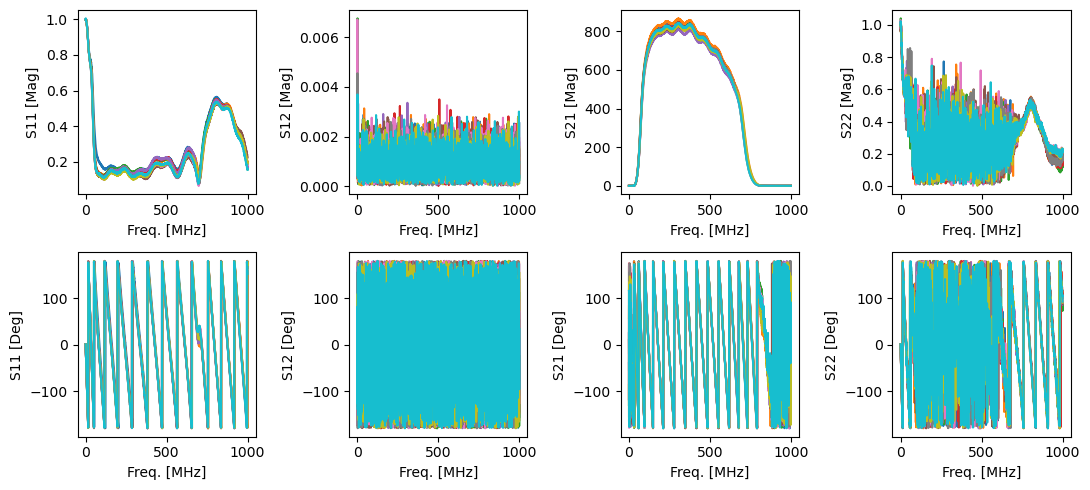

In [426]:
# Display all unmodified data 
fig, axs = plt.subplots(2, 4, figsize=(11, 5))

param_names = ['S11', 'S12', 'S21', 'S22']

for ax, str in zip(axs[0], param_names):
    ax.set_xlabel('Freq. [MHz]')
    ax.set_ylabel(str + ' [Mag]')
    for i in range(len(data)):
        ax.plot(data[0]['FreqHz']/1e6, data[i][str+'MAG'])

for ax, str in zip(axs[1], param_names):
    ax.set_xlabel('Freq. [MHz]')
    ax.set_ylabel(str + ' [Deg]')
    for i in range(len(data)):
        ax.plot(data[0]['FreqHz']/1e6, data[i][str+'DEG'])

fig.tight_layout()

Next, the amplification magnitude is plotted to see the overall trend, more details and distinguish between the channels.

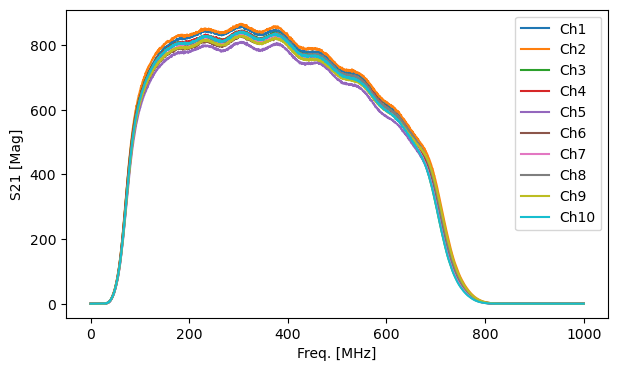

In [425]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.set_xlabel('Freq. [MHz]')
ax.set_ylabel('S21 [Mag]')
for i in range(len(data)):
    ax.plot(data[0]['FreqHz']/1e6, data[i]['S21MAG'], label='Ch{}'.format(i+1))
ax.legend()

The mean amplification magnitude and the difference to each channel are calculated for the full frequency range. The variation between the channels is more visible now.  

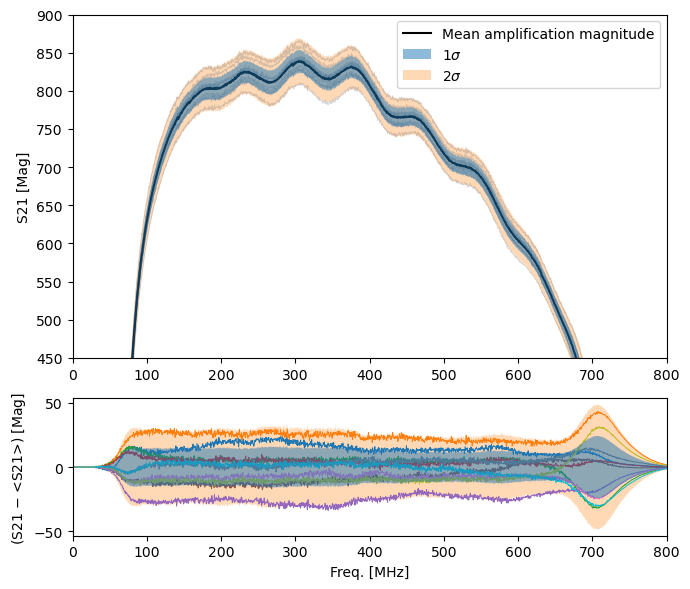

In [392]:
# Mean amplification magnitude 
sum_mag_perFreq = []
for num in range(len(data[0]['FreqHz'])): 
    _ = [data[i]['S21MAG'][num] for i in range(len(data))]
    s = np.sum(_)
    sum_mag_perFreq.append(s)
mean_S21_mag = np.array(sum_mag_perFreq)/len(data)

# Difference to mean amplification curve
diff_to_mean = []
for i in range(len(data)):
    diff = [data[i]['S21MAG'][num] - mean_S21_mag[num] for num in range(len(data[0]['FreqHz']))]
    diff_to_mean.append(diff)

# Calculate standard deviation
std = []
for num in range(len(data[0]['FreqHz'])):
    values = [data[i]['S21MAG'][num] for i in range(len(data))]
    std.append(np.std(values))
std = np.array(std)

# Plot
fig, axs = plt.subplots(2, 1, figsize=(7, 6), height_ratios=[5, 2])

axs[0].set_ylabel('S21 [Mag]')
axs[0].set_ylim(ymin=450, ymax=900)
axs[0].set_xlim(xmin=0, xmax=800)
for i in range(len(data)):
    axs[0].plot(data[0]['FreqHz']/1e6, data[i]['S21MAG'], alpha=0.3, color='grey', linewidth=0.7)
axs[0].plot(data[0]['FreqHz']/1e6, mean_S21_mag, color='k', label='Mean amplification magnitude')
axs[0].fill_between(data[0]['FreqHz']/1e6, mean_S21_mag-std, mean_S21_mag+std, alpha=0.5, label=r'$1\sigma$', zorder=2)
axs[0].fill_between(data[0]['FreqHz']/1e6, mean_S21_mag-2*std, mean_S21_mag+2*std, alpha=0.3, label=r'$2\sigma$', zorder=1)
axs[0].legend()

axs[1].set_xlabel('Freq. [MHz]')
axs[1].set_ylabel(r'(S21 $-$ <S21>) [Mag]')
axs[1].set_xlim(xmin=0, xmax=800)
for i in range(len(diff_to_mean)):
    axs[1].plot(data[0]['FreqHz']/1e6, diff_to_mean[i], linewidth=0.7)
zeros = np.array([0 for i in std])
axs[1].fill_between(data[0]['FreqHz']/1e6, zeros-std, zeros+std, alpha=0.5, zorder=2)
axs[1].fill_between(data[0]['FreqHz']/1e6, zeros-2*std, zeros+2*std, alpha=0.3, zorder=1)

fig.tight_layout()

Next, the bandwidth for each curve is estimated. For that, the cutoff frequencies are defined at the 1/sqrt(2) of maximum magnitude.

In [74]:
# Cutoff frequencies 
cutoff_mags = []
for i in range(len(data)):
    theo_cutoff_mag = 1/np.sqrt(2) * max(data[i]['S21MAG'])
    data_left = [data[i]['S21MAG'][j] for j in range(1000)]
    data_right = [data[i]['S21MAG'][j] for j in range(1000, 2001)]
    cutoff_mag_left = min(data_left, key=lambda x:abs(x-theo_cutoff_mag))
    cutoff_mag_right = min(data_right, key=lambda x:abs(x-theo_cutoff_mag))
    cutoff_mags.append([cutoff_mag_left, cutoff_mag_right])

bandwidths = [] # MHz
for i in range(len(data)):
    cutoff_index_left = np.where(data[i]['S21MAG'] == cutoff_mags[i][0])[0][0]
    cutoff_index_right = np.where(data[i]['S21MAG'] == cutoff_mags[i][1])[0][0]

    cutoff_freq_left = data[i]['FreqHz'][cutoff_index_left]
    cutoff_freq_right = data[i]['FreqHz'][cutoff_index_right]

    bandwidths.append((cutoff_freq_right - cutoff_freq_left)/1e6)


The bandwidths are plotted now together with the mean, standard deviation and rel. deviation of each value to the mean.

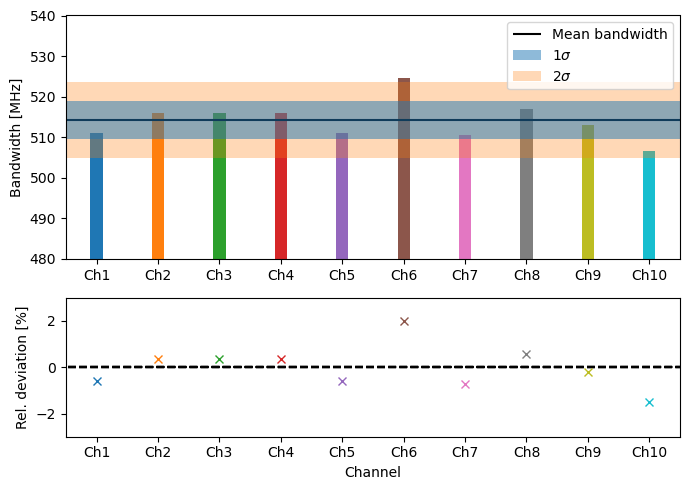

In [407]:
channels = ['Ch{}'.format(i) for i in range(1, 11)]
mean_bandw = np.mean(bandwidths)
std_bandw = np.std(bandwidths)

fig, axs = plt.subplots(2, 1, figsize=(7, 5), height_ratios=(7, 4))

axs[0].set_ylabel('Bandwidth [MHz]')
axs[0].set_ylim(ymin=480, ymax=540)
axs[0].set_xlim(xmin=-0.5, xmax=9.5)
for i in range(len(channels)):
    axs[0].bar(channels[i], bandwidths[i], width=0.2)
axs[0].hlines(y=mean_bandw, xmin=-1, xmax=10, colors='k', label='Mean bandwidth')
axs[0].fill_between(np.linspace(-1 , 11, 13), np.array(mean_bandw)-std_bandw, np.array(mean_bandw)+std_bandw, alpha=0.5, label=r'$1\sigma$', zorder=2)
axs[0].fill_between(np.linspace(-1 , 11, 13), np.array(mean_bandw)-2*std_bandw, np.array(mean_bandw)+2*std_bandw, alpha=0.3, label=r'$2\sigma$', zorder=1)
axs[0].legend()

axs[1].set_xlabel('Channel')
axs[1].set_ylabel('Rel. deviation [%]')
axs[1].set_xlim(xmin=-0.5, xmax=9.5)
axs[1].set_ylim(ymin=-3, ymax=3)
for i in range(len(channels)):
    axs[1].plot(channels[i], (bandwidths[i] - mean_bandw)/mean_bandw * 100, linestyle='', marker='x')
    axs[1].hlines(y=0, xmin=-1, xmax=10, colors='k', linestyle='--')


fig.tight_layout()

In the graph for the amplification curves, one can detect resonance frequencies at the local maxima for each channel at different frequency positions. To get those resonances, all curves are seperated into three windows and the local maximum is calculated. For the (possible) outer resonances the estimation of the local maxima might fail and those frequencies are ignored. 

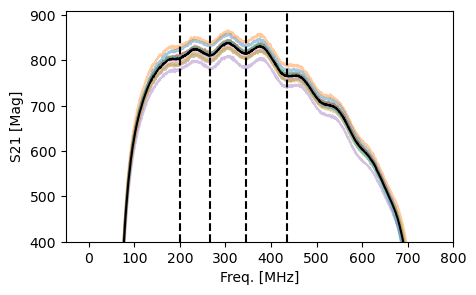

In [329]:
# Set boundaries around visible supposed resonance frequencies for local estimation later 
sum_mag_perFreq = []
for num in range(len(data[0]['FreqHz'])): 
    _ = [data[i]['S21MAG'][num] for i in range(len(data))]
    s = np.sum(_)
    sum_mag_perFreq.append(s)
mean_S21_mag = np.array(sum_mag_perFreq)/len(data)

fig, ax = plt.subplots(figsize=(5, 3))
ax.set_ylabel('S21 [Mag]')
ax.set_xlabel('Freq. [MHz]')
for i in range(len(data)):
    ax.plot(data[0]['FreqHz']/1e6, data[i]['S21MAG'], alpha=0.4)
ax.plot(data[0]['FreqHz']/1e6, mean_S21_mag, color='k')
ax.set_ylim(ymin=400)
ax.set_xlim(xmax=800)
ax.axvline(x=200, color='k', linestyle='--')
ax.axvline(x=265, color='k', linestyle='--')
ax.axvline(x=345, color='k', linestyle='--')
ax.axvline(x=435, color='k', linestyle='--')

In [350]:
# Search local maxima to find resonance frequencies

boundary_index = np.round((np.array([200, 265, 345, 435]) 
                           - min(data[0]['FreqHz']/1e6)) * len(data[0])/max(data[0]['FreqHz']/1e6), 0)
b_int = boundary_index.astype(int)

maxima = [[max(data[i]['S21MAG'][b_int[0]:b_int[1]]), max(data[i]['S21MAG'][b_int[1]:b_int[2]]), max(data[i]['S21MAG'][b_int[2]:b_int[3]])] for i in range(len(data))]

res_freq = []
for i in range(len(data)):
    res_freq.append([data[i]['FreqHz'][np.where(data[i]['S21MAG'] == maxima[i][j])[0][0]]/1e6 for j in range(len(maxima[i]))])

std_freq = []
for i in range(len(channels[0])):
    freqs = [res_freq[j][i] for j in range(len(channels))]
    std_freq.append(np.std(freqs))

The three found resonance frequencies are compared between all channels and the relative deviation is displayed again (next figure).

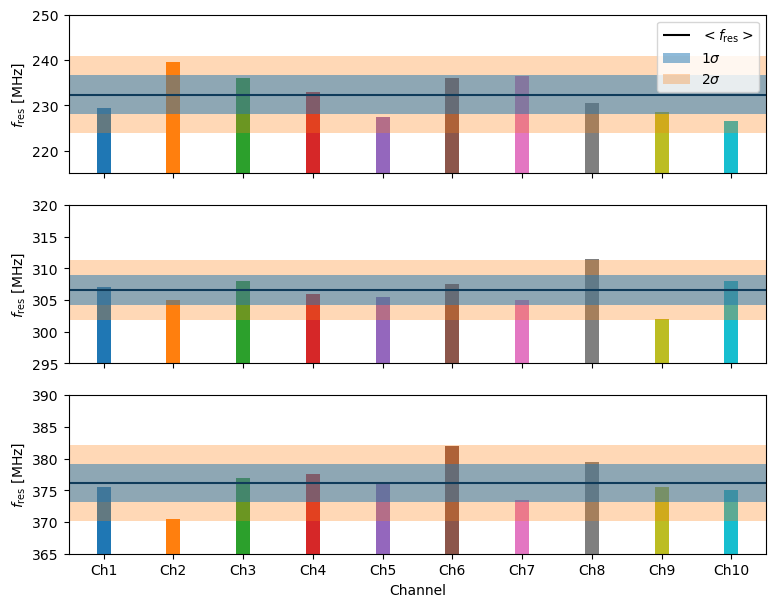

In [403]:
channels = ['Ch{}'.format(i) for i in range(1, 11)]

fig, axs = plt.subplots(3, 1, figsize=(9, 7))

axs[0].xaxis.set_ticklabels([])
axs[0].set_ylabel(r'$f_{\rm res}$ [MHz]')
axs[0].set_ylim(ymin=215, ymax=250)
axs[0].set_xlim(xmin=-0.5, xmax=9.5)
for i in range(len(channels)):
    axs[0].bar(channels[i], res_freq[i][0], width=0.2)
mean_freq_1 = np.mean([res_freq[i][0] for i in range(len(channels))])
axs[0].hlines(y=mean_freq_1, xmin=-1, xmax=10, color='k', label=r'$<f_{\rm res}>$')
axs[0].fill_between(np.linspace(-1 , 11, 13), mean_freq_1-std_freq[0], mean_freq_1+std_freq[0], alpha=0.5, label=r'$1\sigma$', zorder=2)
axs[0].fill_between(np.linspace(-1 , 11, 13), mean_freq_1-2*std_freq[0], mean_freq_1+2*std_freq[0], alpha=0.3, label=r'$2\sigma$', zorder=1)
axs[0].legend()

axs[1].xaxis.set_ticklabels([])
axs[1].set_ylabel(r'$f_{\rm res}$ [MHz]')
axs[1].set_ylim(ymin=295, ymax=320)
axs[1].set_xlim(xmin=-0.5, xmax=9.5)
for i in range(len(channels)):
    axs[1].bar(channels[i], res_freq[i][1], width=0.2)
mean_freq_2 = np.mean([res_freq[i][1] for i in range(len(channels))])
axs[1].hlines(y=mean_freq_2, xmin=-1, xmax=10, color='k', label=r'$<f_{\rm res}>$')
axs[1].fill_between(np.linspace(-1 , 11, 13), mean_freq_2-std_freq[1], mean_freq_2+std_freq[1], alpha=0.5, label=r'$1\sigma$', zorder=2)
axs[1].fill_between(np.linspace(-1 , 11, 13), mean_freq_2-2*std_freq[1], mean_freq_2+2*std_freq[1], alpha=0.3, label=r'$2\sigma$', zorder=1)

axs[2].set_xlabel('Channel')
axs[2].set_ylabel(r'$f_{\rm res}$ [MHz]')
axs[2].set_ylim(ymin=365, ymax=390)
axs[2].set_xlim(xmin=-0.5, xmax=9.5)
for i in range(len(channels)):
    axs[2].bar(channels[i], res_freq[i][2], width=0.2)
mean_freq_3 = np.mean([res_freq[i][2] for i in range(len(channels))])
axs[2].hlines(y=mean_freq_3, xmin=-1, xmax=10, color='k', label=r'$<f_{\rm res}>$')
axs[2].fill_between(np.linspace(-1 , 11, 13), mean_freq_3-std_freq[2], mean_freq_3+std_freq[2], alpha=0.5, label=r'$1\sigma$', zorder=2)
axs[2].fill_between(np.linspace(-1 , 11, 13), mean_freq_3-2*std_freq[2], mean_freq_3+2*std_freq[2], alpha=0.3, label=r'$2\sigma$', zorder=1)

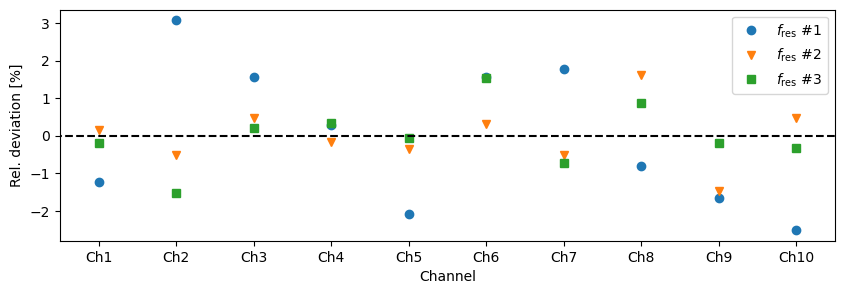

In [424]:
channels = ['Ch{}'.format(i) for i in range(1, 11)]
mean_freq_1 = np.mean([res_freq[i][0] for i in range(len(channels))])
mean_freq_2 = np.mean([res_freq[i][1] for i in range(len(channels))])
mean_freq_3 = np.mean([res_freq[i][2] for i in range(len(channels))])

fig, ax = plt.subplots(figsize=(10, 3))

#axs[0].set_ylim(ymin=215, ymax=250)
ax.set_xlim(xmin=-0.5, xmax=9.5)
ax.set_xlabel('Channel')
ax.set_ylabel('Rel. deviation [%]')
ax.plot(channels, ([res_freq[i][0] for i in range(len(channels))] - mean_freq_1)/mean_freq_1 * 100, 
        marker='o', linestyle='', label=r'$f_{\rm res}$ #1')
ax.plot(channels, ([res_freq[i][1] for i in range(len(channels))] - mean_freq_2)/mean_freq_2 * 100, 
        marker='v', linestyle='', label=r'$f_{\rm res}$ #2')
ax.plot(channels, ([res_freq[i][2] for i in range(len(channels))] - mean_freq_3)/mean_freq_3 * 100, 
        marker='s', linestyle='', label=r'$f_{\rm res}$ #3')
ax.hlines(y=0, xmin=-1, xmax=10, color='k', linestyle='--')
ax.legend()


The phase plots can provide clues about potential stability issues and therefore S12 and S21 are shown last to see their unique behaviors over a small frequency range in more detail. 

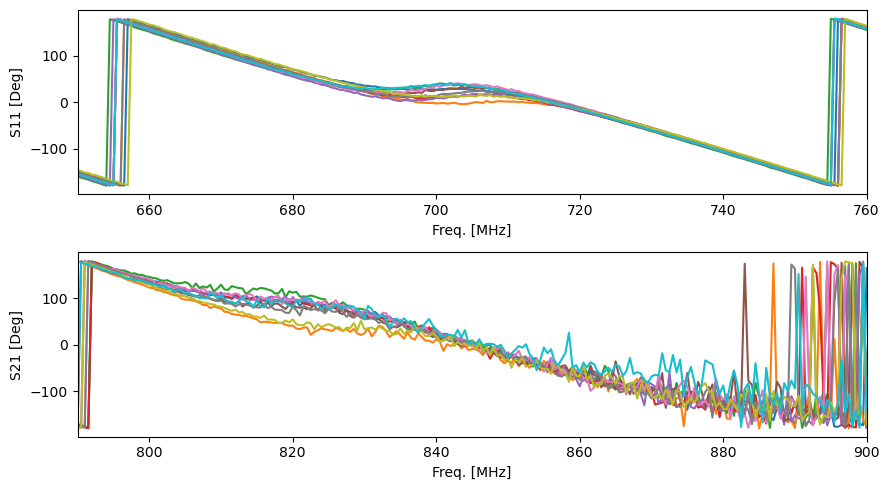

In [49]:
fig, axs = plt.subplots(2, 1, figsize=(9, 5))

# Window for S11 650-760 MHz
axs[0].set_xlabel('Freq. [MHz]')
axs[0].set_ylabel('S11 [Deg]')
for i in range(len(data)):
    axs[0].plot(data[0]['FreqHz']/1e6, data[i]['S11DEG'])
axs[0].set_xlim(xmin=650, xmax=760)

# Window for S21 790-900 MHz 
axs[1].set_xlabel('Freq. [MHz]')
axs[1].set_ylabel('S21 [Deg]')
for i in range(len(data)):
    axs[1].plot(data[0]['FreqHz']/1e6, data[i]['S21DEG'])
axs[1].set_xlim(xmin=790, xmax=900)

fig.tight_layout()

To summarize the results of the analysis of the amplifier data, one can say that, if one (e.g. the manufacturer) defines a maximum spread in magnitude of e.g. +-15 mag to call the amplifiers 'identical', the criterion would not be fulfilled with this data. But it depends on that defined limit of course, and the production of the amplifiers could be called uniform if the allowed variation is set more conservative (e.g. < +-50 mag). 

This is also true for the deviation between the bandwidths and resonance frequencies of the different channels, where the tolerance should be set above 2% and 3%, respectively, to call the amplifiers uniform or identical.  